In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 
from collections import deque

import evoenv
from evoenv.matrixtools import FloatTupleDtype
from evoenv.envs.enumerated_stochastic_game import MatrixGame
import ray
ray.init()

2024-02-25 11:29:09,921	INFO worker.py:1642 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.7.0


### General Utils

In [2]:
def make_one_hot_dict(num_actions = 4):
    """
    Description: This method returns a dictionary of one hot encodings
    """
    one_hot_dict = {}
    for x in range(0, num_actions):
        one_hot_dict[x] = [0 for y in range(0, num_actions)]
        one_hot_dict[x][x] = 1
    return one_hot_dict


def get_init_state_dist(players):
    states = [[0, 0, 0, 0],
          [1, 0, 1, 0],
          [1, 0, 0, 1],
          [0, 1, 1, 0],
          [0, 1, 0, 1]]
    
    df = pd.DataFrame()
    for player in players:
        tmp = {}
        
        for state in states:
            _, _, output, _ = player.policy(torch.tensor(state, dtype=torch.float))
            tmp[''.join(str(state))] = output.detach().numpy()[0]
            tmp = pd.DataFrame(tmp, index=[0])

        tmp['player_id'] = player.player_id
        df = pd.concat([df, tmp])
    return df


def plot_init_state_dist(df):
    states = [[0, 0, 0, 0],
          [1, 0, 1, 0],
          [1, 0, 0, 1],
          [0, 1, 1, 0],
          [0, 1, 0, 1]]
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharey=True)
    for idx, state in enumerate(states):

        axs[idx // 2, idx % 2].hist(df[str(state)],bins=20, density=False)
        axs[idx // 2, idx % 2].set_title(f'state: {state}')
        axs[idx // 2, idx % 2].set_xlabel("Initial Cooperation Value")

        axs[idx // 2, idx % 2].grid(True)
    plt.tight_layout(pad=2.5)
    plt.suptitle(f'Init State Dist')
    plt.show()
    
    
def show_payoff_mat(payoff_matrix):
    vals = np.array([sum(x) for x in payoff_matrix.flatten()]).reshape(payoff_matrix.shape)
    annots = np.array([str(x) for x in payoff_matrix.flatten()], dtype='str').reshape(payoff_matrix.shape)
    print("Error in matplotlib for displaying annotations.  Payoff matrix is:")
    print(annots)

    sns.heatmap(vals, annot=annots, fmt='', linewidth=.5)

    plt.title('Payoff Matrix')

    plt.xticks([x + 0.5 for x in range(2)], ['C', 'D'])
    plt.yticks([x + 0.5 for x in range(2)], ['C', 'D'])

    plt.show()
    
    
def make_plots(df, N):
    means = df.groupby('round').aggregate({'total_reward': 'mean'}).reset_index()
    plt.figure(figsize=(12, 12))
    plt.plot(means['round'], means['total_reward']/2, label='total_reward')
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('Round')
    plt.ylabel('Mean Reward')
    plt.title(f'Population Size: {N}')
    plt.show()
    return 1

### Payoff matrix

In [3]:
def prisoner_dilemna_payoff(b, c):
    R = b - c
    S = -c
    T = b
    P = 0

    rewards = np.array(
      [
        [(R, R), (S, T)],
        [(T, S), (P, P)]
      ], dtype=FloatTupleDtype(2)
    )

    return rewards

### Networks

In [276]:
def identity(x):
    """Return input without any change."""
    return x


class MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 output_limit=1.0,
                 hidden_sizes=(64,64), 
                 activation=F.relu, 
                 output_activation=identity,
                 use_output_layer=True,
                 use_actor=False,
                 initialization='uniform'):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.output_limit = output_limit
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.use_output_layer = use_output_layer
        self.use_actor = use_actor

        if initialization == 'uniform':
            self.initialization = torch.nn.init.uniform_
        elif initialization == 'normal':
            self.initialization = torch.nn.init.normal_

        # Set hidden layers
        self.hidden_layers = nn.ModuleList()
        in_size = self.input_size
        for next_size in self.hidden_sizes:
            fc = nn.Linear(in_size, next_size)

            if initialization == 'dirichlet':
                alpha = torch.tensor([0.5 for x in range (fc.weight.shape[1])])  # concentration parameters
                dirichlet = torch.distributions.Dirichlet(alpha)
                samples = dirichlet.sample([fc.weight.shape[0],])
                fc.weight.data = samples
            else:
                self.initialization(fc.weight)

            in_size = next_size
            self.hidden_layers.append(fc)

        # Set output layers
        if self.use_output_layer:
            self.output_layer = nn.Linear(in_size, self.output_size)

            if initialization == 'dirichlet':
                alpha = torch.tensor([0.5 for x in range (self.output_layer.weight.shape[1])])  # concentration parameters
                dirichlet = torch.distributions.Dirichlet(alpha)
                samples = dirichlet.sample([self.output_layer.weight.shape[0],])
                self.output_layer.weight.data = samples
            else:
                self.initialization(self.output_layer.weight)
        else:
            self.output_layer = identity


    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_activation(self.output_layer(x))
        # If the network is used as actor network, make sure output is in correct range
        x = x * self.output_limit if self.use_actor else x   
        return x

class CategoricalPolicy(MLP):
    def __init__(self,
                 input_size,
                 output_size,
                 hidden_sizes=(64,),
                 activation=torch.relu,
                 initialization='uniform',
                 temperature=0.1
    ):
        super(CategoricalPolicy, self).__init__(
            input_size=input_size,
            output_size=output_size,
            hidden_sizes=hidden_sizes,
            activation=activation,
            initialization=initialization)
        self.temperature = temperature

    def forward(self, x, pi=None, use_pi=True):
        x = super(CategoricalPolicy, self).forward(x)
        pi = F.softmax(x/self.temperature, dim=-1)

        dist = torch.distributions.categorical.Categorical(pi)
        action = dist.sample()

        log_pi = dist.log_prob(action)
        return action, None, pi, log_pi


### Player Class

In [277]:
class Player():
    """
    Description:  A class to describe the player.  This class stores relavant
    player information such as:

    This class will also provide a way to update player policies.
    """
    def __init__(self,
                 obs_dim,
                   act_dim,
                   memory=1,
                   device="cpu",
                   player_id=None):

        # generate random player id if not passed
        if player_id == None:
            self.player_id = np.random.randint(0, 1000000)
        else:
            self.player_id = player_id

        self.memory = memory
        self.obs_dim = obs_dim
        self.act_dim = act_dim

        self.device = device




class VPGPlayer2(Player):
    """
    An implementation of the Vanilla Policy Gradient agent,
    with early stopping based on approximate KL.
    """

    def __init__(self,
                 base_player_params,
                 actor_model_params,
                 training_params
                 ):

        # S/A/R histories
        self.states = []
        self.actions = []
        self.rewards = []
        
        # initialize player object params
        super().__init__(**base_player_params)

        self.steps = 0

        self.policy_lr = training_params.get('policy_lr', 0.01)
        self.policy_target = training_params.get('policy_target', 0)

        # Main network
        self.policy = CategoricalPolicy(**actor_model_params).to(self.device)

        # Create optimizers
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.policy_lr)


    def select_action(self, obs):
        action, _, probs, log_pi = self.policy(torch.Tensor(obs).to(self.device))
        return action.detach().cpu().numpy().flatten()[0]

    def train_model(self):

        # get everything in buffer (rather than sample)
        self.rewards = torch.tensor(np.array(self.rewards))
        tmp = np.array(self.rewards) * (gamma ** np.arange(len(self.rewards)))
        self.rewards = torch.tensor(tmp)

        self.states = torch.tensor(np.array(self.states), dtype=torch.float32)
        self.actions = torch.tensor(np.array(self.actions))
        
        #total_reward = torch.sum(self.rewards)
        
        policy_target = (self.rewards - self.policy_target)

        _, _, probs, _ = self.policy(self.states)
        
        # get probs/log probs of each action
        probs = torch.distributions.categorical.Categorical(probs)
        
        log_probs = probs.log_prob(self.actions)

        # Total reward formulation
        loss = torch.sum(-log_probs * policy_target)

        # update policy weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # check gradients
        #print("Learning Rate:", self.optimizer.param_groups[0]['lr'])
        #for val in self.policy.parameters():
        #    print(val.grad)

        # clear hist
        self.states = []
        self.actions = []
        self.rewards = []


    def save_network(self):
        torch.save(self.policy.state_dict(),
                   f'{self.save_path}/{self.color}/{self.population}/VPG_Player_{self.player_id}_PN_SD.csv')
        return 1

    def save_policy(self, df2, cols=['A1', 'A2', 'A3', 'A4']):
        df = df2.copy()
        df[cols] = df.apply(lambda row: self.policy(torch.Tensor(row))[2].detach().numpy(), axis=1,
                            result_type='expand')
        df[cols] = np.exp(df[cols])
        df[cols] = df[cols] / np.sum(df[cols], axis=0)
        df.to_csv(f'{self.save_path}/{self.color}/{self.population}/VPG_Player_{self.player_id}_PN.csv')
        print("Player Info Saved")

        return 1

### Population Functions

In [278]:
def generate_population(N, base_player_params, actor_model_params, training_params):
    players = []
    for i in range(0, N):
        base_player_params['player_id'] = i
        player = VPGPlayer2(base_player_params,
                            actor_model_params,
                            training_params)
        players.append(player)
    return np.array(players)

def random_pairing(input_list):
    """"
    Description: This function will pair players randomly and ignore specific red/blue players
    """
    # Convert the list to a numpy array
    array = np.array(input_list)

    # Shuffle the array in-place
    np.random.shuffle(array)

    # Reshape the array into pairs
    pairings = array.reshape(-1, 2)

    # If the original list has an odd number of elements, the last element will be unpaired
    # You can choose to handle it separately or ignore it based on your requirements
    return np.array(pairings)[np.newaxis,:]


### Play Game

In [316]:
@ray.remote
def play_game(env, players, timesteps, device='cpu', debug=True):
    """
    Description:  This function will play a single game between players in array
    some starting state.  The resulting networks of the players will be updated in place.

    Inputs:
      env: The environment in which p1 and p2 compete
      players: a list of players
      timesteps: the amount of timesteps to run the game for
    Output:
      env: updated environment
      players: with modified policeis
      df: a dataframe with statistics on the game
    """
    if debug:
        print(f'Starting interaction between p1_id:{players[0].player_id}, p2_id:{players[1].player_id} with {timesteps} timesteps')

    df = pd.DataFrame()

    state, actions = env.reset()

    # map these actions to numeric moves
    # for grid world
    action_space = 2
    action_map = {0:"C",1: "D"}
    one_hot_dict = make_one_hot_dict(action_space)

    # starting state for each player
    for player in players:
        player.states.append([0, 0, 0, 0])
    
    # do this loop until terminal state
    for i in range(timesteps):
        actions = []
        one_hot_actions = []
        
        # select an action for each player
        for idx, player in enumerate(players):
            # from this we create the state vector for the particular player
            action = player.select_action(player.states[-1])
            one_hot_actions.append(one_hot_dict[action])
            actions.append(action)

        observation, _, rewards, _ = env.step(tuple(actions))

        # flatten this for state storage

        one_hot_actions = [action for sublist in one_hot_actions for action in sublist]
        for idx, player in enumerate(players):
            if idx!= 0:
                # move these elemtns to first position
                elements_to_move = one_hot_actions[idx*2:idx*2+2]
                one_hot_actions = one_hot_actions[:idx*2] + one_hot_actions[idx*2+2:]
                one_hot_actions = elements_to_move + one_hot_actions
        
            player.states.append(one_hot_actions)
            player.actions.append(actions[idx])
            player.rewards.append(rewards[idx])
        
        tmp = record_results(players, start_timestep=i, end_timestep=i+1)
        df = pd.concat([df, tmp])

    if debug:
        print("Interaction Complete")
    # Train players at the end of the encounter
    for idx, player in enumerate(players):
        # remove next observation
        player.states = player.states[:-1]
        player.train_model()
            
    return df, players


def play_paired_games(env, players, player_pairs, device='cpu', debug=True):
    """
    Description:  This function will play all of the games in the player_pairs
    matrix and record episodic rewards

    Inputs:
      env: environment in which players will play
      player_pair: a matrix of player ids pairings who will play agains each other
      players: a list of player objects
    Outputs:
      df: a dataframe with statistics on the game
    """

    prob = 1 - gamma
    tmp = ray.get([play_game.remote(env = env, 
                                       players = players[player_pairs[x, y].astype(int)], 
                                       timesteps = int(1/(1-gamma)), #np.random.geometric(prob, size=1)[0], 
                                       device = device, 
                                       debug = debug) for x in range(player_pairs.shape[0])\
                                              for y in range(player_pairs.shape[1])]) 

    dfs = pd.concat([tmp[x][0] for x in range(len(tmp))])
        
    players_list = [tmp[x][1] for x in range(len(tmp))]
    players = [player for sublist in players_list for player in sublist]
    players = sorted(players, key=lambda x: x.player_id)

    return dfs, np.array(players)

In [317]:
def record_results(players, start_timestep, end_timestep):
    """
    Description: Log results of the particular game between 2 players
    """
    
    mutual_cooperation_flag = 0
    mutual_defection_flag = 0
    exploit_flag = 0
    p1_exploit_flag = 0
    p2_exploit_flag = 0
    # action zero = cooperate, action 1 = defect based on payoff defined in cg_utils

    if (players[0].actions[-1] == 1) & (players[1].actions[-1] == 1):
        mutual_defection_flag = 1

    elif (players[0].actions[-1] == 0) & (players[1].actions[-1] == 0):
        mutual_cooperation_flag = 1

    # p1 exploits p2
    elif (players[0].actions[-1] == 1) & (players[1].actions[-1] == 0):
        p1_exploit_flag = 1
        exploit_flag = 1

    # p2 exploits p1
    else:
        p2_exploit_flag = 1
        exploit_flag = 1


    # store metrics related to the episode
    tmp = {
      'start_timestep':start_timestep,
      'end_timestep':end_timestep,
      'episode_length':end_timestep - start_timestep,
      'p1_reward':players[0].rewards[-1],
      'p2_reward':players[1].rewards[-1],
      'total_reward': players[0].rewards[-1] + players[1].rewards[-1],
      'p1_state':', '.join(map(str, players[0].states[-1])),
      'p2_state':', '.join(map(str, players[1].states[-1])), # adding these to see if we can optimize behavior in particular states
      'p1_action':players[0].actions[-1],
      'p2_action':players[1].actions[-1],
      'mutual_cooperation_flag':mutual_cooperation_flag,
      'mutual_defection_flag':mutual_defection_flag,
      'exploit_flag': exploit_flag,
      'p1_exploit_flag':p1_exploit_flag,
      'p2_exploit_flag':p2_exploit_flag,
      'p1_id':players[0].player_id,
      'p2_id':players[1].player_id}

    return pd.DataFrame(tmp, index=[0])
   

### Settings

#### Environment

In [318]:
input_size = 4 # state space (current state, previous state, p1 action, p2 action)
output_size = 2 # action space

# prisoners dilemna setting
b = 3
c = -3

N = 10 # populationsize
gamma = 0.95 # interaction length
rounds = 100 # number of interactions to play

rewards = prisoner_dilemna_payoff(b, c)
env = evoenv.envs.MatrixGame(rewards)

fix_pairings = 1 # 0 means new opponents each round, 1 means same opponenet all rounds

Error in matplotlib for displaying annotations.  Payoff matrix is:
[['(6., 6.)' '(3., 3.)']
 ['(3., 3.)' '(0., 0.)']]


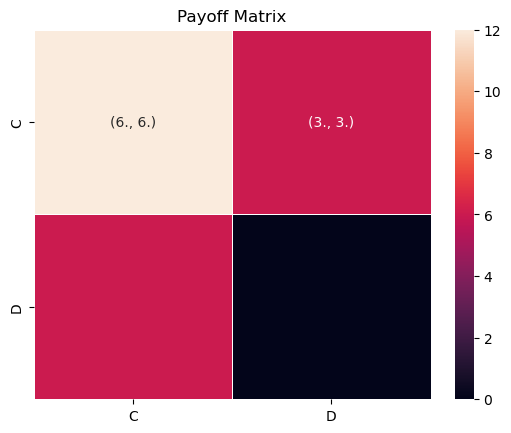

In [319]:
show_payoff_mat(rewards)

#### Player

In [320]:
########### Model Params #############
hidden_size = input_size * 4
activation = F.relu # hidden layer activation
initialization = 'uniform' # network weight initialization
temperature = 1 # to softmax policy

########### Training Params ###########
policy_lr = 0.01

policy_target = (sum(rewards[0][0]) + sum(rewards[0][1]) + sum(rewards[1][0]) + sum(rewards[1][1])) / 4
# policy gradient target mean reward

########### Other Params ###########
memory = 1 # player memory

#### Other Params

In [321]:
device = 'cpu'
debug = False

#### Now just formatting these params

In [322]:
actor_model_params = {'input_size':input_size,
                    'hidden_sizes':(hidden_size, ),
                    'output_size':output_size,
                    'activation':activation,
                    'initialization':initialization,
                    'temperature':temperature}

training_params = {'policy_lr':policy_lr,
                    'policy_target':policy_target}

base_player_params = {'memory':memory,
                       'obs_dim':input_size,
                       'act_dim':output_size}

### Generate Population

In [323]:
players = generate_population(N, base_player_params, actor_model_params, training_params)

In [324]:
print(f'Player id {players[0].player_id}\n')
print(f'Player Policy: {players[0].policy}\n')

#print(f'Player id {players[5].player_id}\n')
#print(f'Player Policy: {players[5].policy}')

Player id 0

Player Policy: CategoricalPolicy(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
)



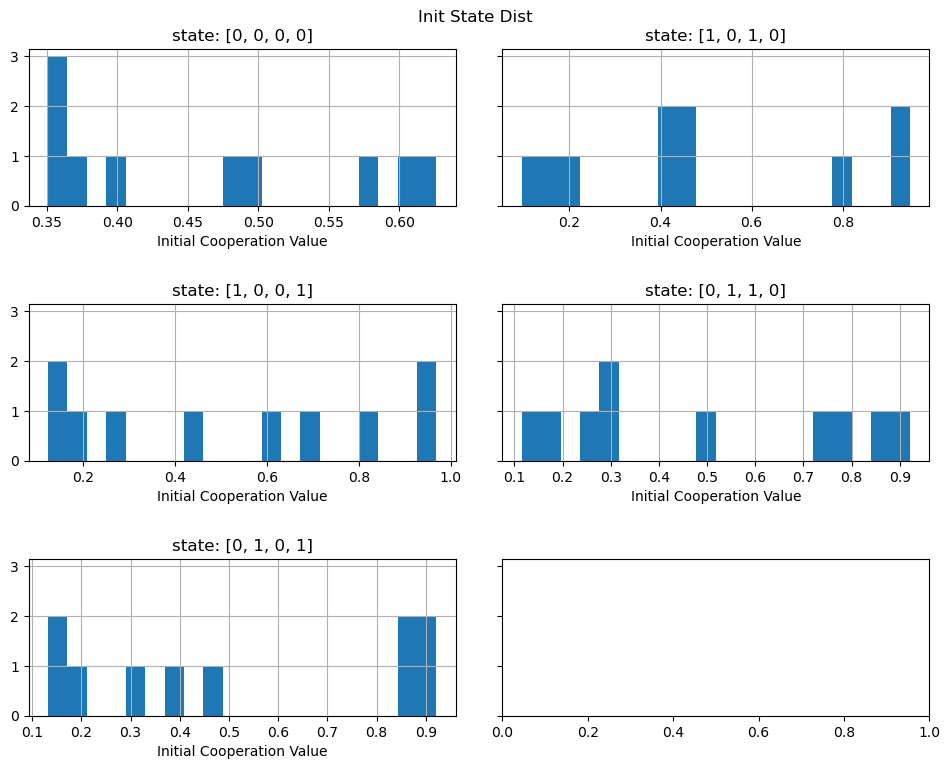

In [325]:
init_pop_dist = get_init_state_dist(players)
plot_init_state_dist(init_pop_dist)

In [326]:
players[1].policy(torch.tensor([1,0,1,0], dtype=torch.float32))

(tensor(1),
 None,
 tensor([0.2003, 0.7997], grad_fn=<SoftmaxBackward0>),
 tensor(-0.2235, grad_fn=<SqueezeBackward1>))

In [327]:
players[0].policy(torch.tensor([1,0,1,0], dtype=torch.float32))

(tensor(0),
 None,
 tensor([0.9478, 0.0522], grad_fn=<SoftmaxBackward0>),
 tensor(-0.0536, grad_fn=<SqueezeBackward1>))

### This is the main loop

In [328]:
# initialize output df
df = pd.DataFrame()
player_pairs = []

# initialize game, payoff, rewards, rounds, etc.
state, actions = env.reset()
policy_df = pd.DataFrame()
for round_idx in range(rounds):
    start = datetime.now()
    print(f'Round {round_idx}, Start Time {start}')

    # if are fixing pairs we only do this once
    # ie, when player pairings is first initialized
    if (fix_pairings == 0) or (len(player_pairs) == 0):
        player_pairs = random_pairing([x for x in range(N)])
        
    if debug:
        print("The following players will be paired this round")
        print(player_pairs)
        
    # play all the games in player_pairings and record reward
    tmp, players = play_paired_games(env,players, player_pairs, device, debug)

    end = datetime.now()
    total_time = end-start

    tmp['round'] = round_idx
    tmp['round_time'] = total_time

    df = pd.concat([df, tmp])

Round 0, Start Time 2024-02-25 19:59:36.775984
Round 1, Start Time 2024-02-25 19:59:37.068092
Round 2, Start Time 2024-02-25 19:59:37.427504
Round 3, Start Time 2024-02-25 19:59:37.682438
Round 4, Start Time 2024-02-25 19:59:38.042684
Round 5, Start Time 2024-02-25 19:59:38.345930
Round 6, Start Time 2024-02-25 19:59:38.611897
Round 7, Start Time 2024-02-25 19:59:38.830142
Round 8, Start Time 2024-02-25 19:59:39.051533
Round 9, Start Time 2024-02-25 19:59:39.451302
Round 10, Start Time 2024-02-25 19:59:39.715462
Round 11, Start Time 2024-02-25 19:59:40.033441
Round 12, Start Time 2024-02-25 19:59:40.345080
Round 13, Start Time 2024-02-25 19:59:40.612765
Round 14, Start Time 2024-02-25 19:59:40.953247
Round 15, Start Time 2024-02-25 19:59:41.246110
Round 16, Start Time 2024-02-25 19:59:41.479170
Round 17, Start Time 2024-02-25 19:59:41.702801
Round 18, Start Time 2024-02-25 19:59:41.926679
Round 19, Start Time 2024-02-25 19:59:42.147677
Round 20, Start Time 2024-02-25 19:59:42.387504
Ro

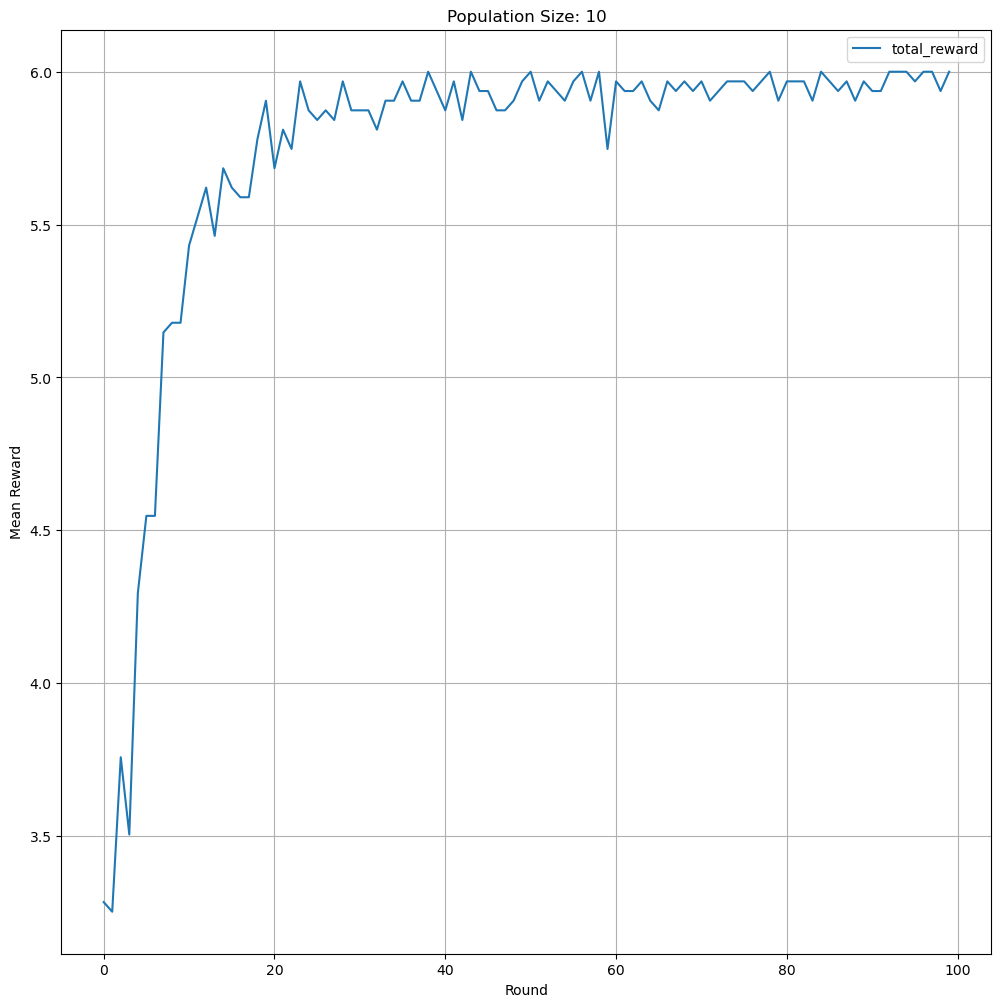

1

In [330]:
make_plots(df, N)

In [331]:
np.array([1, 1, 1, 1]) * 0.99 ** np.arange(4)

array([1.      , 0.99    , 0.9801  , 0.970299])

In [332]:
multipliers = 0.99 ** np.arange(4)

In [333]:
multipliers

array([1.      , 0.99    , 0.9801  , 0.970299])

In [334]:
df

,start_timestep,end_timestep,episode_length,p1_reward,p2_reward,total_reward,p1_state,p2_state,p1_action,p2_action,mutual_cooperation_flag,mutual_defection_flag,exploit_flag,p1_exploit_flag,p2_exploit_flag,p1_id,p2_id,round,round_time
0,0,1,1,3.0,3.0,6.0,"1, 0, 0, 1","0, 1, 1, 0",0,1,0,0,1,0,1,7,4,0,0 days 00:00:00.291209
0,1,2,1,3.0,3.0,6.0,"1, 0, 0, 1","0, 1, 1, 0",0,1,0,0,1,0,1,7,4,0,0 days 00:00:00.291209
0,2,3,1,3.0,3.0,6.0,"1, 0, 0, 1","0, 1, 1, 0",0,1,0,0,1,0,1,7,4,0,0 days 00:00:00.291209
0,3,4,1,3.0,3.0,6.0,"1, 0, 0, 1","0, 1, 1, 0",0,1,0,0,1,0,1,7,4,0,0 days 00:00:00.291209
0,4,5,1,3.0,3.0,6.0,"1, 0, 0, 1","0, 1, 1, 0",0,1,0,0,1,0,1,7,4,0,0 days 00:00:00.291209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,14,15,1,6.0,6.0,12.0,"1, 0, 1, 0","1, 0, 1, 0",0,0,1,0,0,0,0,8,2,99,0 days 00:00:00.219835
0,15,16,1,6.0,6.0,12.0,"1, 0, 1, 0","1, 0, 1, 0",0,0,1,0,0,0,0,8,2,99,0 days 00:00:00.219835
0,16,17,1,6.0,6.0,12.0,"1, 0, 1, 0","1, 0, 1, 0",0,0,1,0,0,0,0,8,2,99,0 days 00:00:00.219835
0,17,18,1,6.0,6.0,12.0,"1, 0, 1, 0","1, 0, 1, 0",0,0,1,0,0,0,0,8,2,99,0 days 00:00:00.219835


In [297]:
1/0.05

20.0

In [335]:
df['start_timestep'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])